<a href="https://colab.research.google.com/github/aleksejalex/01ZLMA_forked/blob/main/Python/01ZLMA_ex04_GLM_model_testing_and_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01ZLMA - Exercise 04

Exercise 04 of the course 01ZLMA. 

## Contents

* Statistical Inference - part 2
 ---
* Testing - part 2
 ---
* Model comparison
 ---
* Model selection
 ---


# Download custom library from GitHub
(using `wget` library)

In [ ]:
# Please note that this cell works may not work in other env-s that Google Colab
!pip install wget
import wget
url = "https://github.com/francji1/01ZLMA/raw/main/Python/helpers.py"
wget.download(url, '../content/helpers.py')  # path where Colab can find libraries

In [ ]:
import numpy as np
import scipy
from scipy import stats

import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.api import abline_plot

import pandas as pd

from helpers import Anova

sns.set_theme()

In [ ]:
# download dataset 'nminers.csv', used in R as a part of 'GLMsData' package (https://cran.r-project.org/web/packages/GLMsData/index.html)
# Note: I couldn't find the dataset available online, so I exported it from R directly via command 'write.csv(nminer,file="nminer_exported_from_R.csv")'

nminer = pd.read_csv("https://github.com/aleksejalex/special-octo-engine/raw/main/datasets/nminer_exported_from_R.csv")
nminer.head()

In [ ]:
nminer.describe()


In [ ]:
g = sns.PairGrid(nminer)
g.map_diag(sns.kdeplot)
g.map_lower(sns.scatterplot)
g.map_upper(sns.histplot)

plt.show()

In [ ]:
corr = nminer.corr()
sns.heatmap(corr, cmap='cividis', annot=True)

plt.show()

In [ ]:

sns.scatterplot(data=nminer, x="Eucs", y="Minerab")

plt.show()

In [ ]:
model_1 = smf.glm(formula='Minerab~Eucs', data=nminer, family=sm.families.Poisson()).fit(maxiter=2,
                                                                          tol=1e-15)
model_1.summary2()



 The estimates $\beta^j$ are found by Fisher scoring, using the
iteratively reweighted least squares algorithm.

The covariance matrix of the regression
parameters is estimated from inverse information matrix

$$ var[\hat{\beta}] = I^{-1} = \phi (X^T \hat{W} X)^{-1}$$
and 
$$ se[\hat{\beta}_j] = \sqrt{\phi} v_j,$$

where the $v_j$ are the square-root diagonal elements of $(X^T \hat{W} X)^{-1}$.

In [ ]:
cov_mat = model_1.cov_params()
# Covariance matrix
print(f'Covariance matrix:  \n {np.round(cov_mat, decimals=4)}')
# Square-root of its diagonal elements 
print(f'Variances are: {np.sqrt(np.diag(cov_mat))}')

#model_1.params

## Wald Tests for Single Regression Coefficients

The Wald test of the null hypothesis $H_0: \beta_j = \beta_j^0$, where $\beta_j^0$ is typically zero.



In [ ]:
m1 = smf.glm(formula='Minerab~Eucs', data=nminer, family=sm.families.Poisson())
model_1 = m1.fit()
print(model_1.summary2())
print(f'Conf. intervals are: {model_1.conf_int()}')


## Confidence Intervals for Individual Coefficients


## Confidence Intervals for $\mu$

The variance of $\hat{\mu}$ is found by first considering $\hat{\eta}$. Consider given values of the $p$ explanatory variables ${x_{new}}$. The variance of  $\hat{\eta}$ is
$$ var[ \hat{\eta}] = var[x_{new} \hat{\beta}] = x_{new}(X^T \hat{W} X)^{-1} x_{new}^T$$
where some estimate of $\phi$ must be used if the value of $\phi$ is unknown. 

The variance of $\hat{\eta}$ is harder to compute directly. However, for inference involving $\mu$ (such as confidence intervals for $\mu$), we work with $\hat{\eta}$ and then convert to $\hat{\mu}$ by
$$ \mu = g^{-1}(\eta).$$



In [ ]:
# By default, this computes statistics on the linear predictor scale:
out = model_1.predict( exog=pd.DataFrame(data={'Eucs': np.array([10])})) 
# Return predictions on mu scale
out2 = model_1.predict( exog=pd.DataFrame(data={'Eucs': np.array([10])}), linear=False) 
# Both methods give the same answer

print(out, out2)

In [ ]:

newEucs = np.linspace(0, 35, 100)

newMab = model_1.predict(exog=pd.DataFrame({'Intercept': np.ones((100,)),'Eucs': newEucs}), linear=True).to_numpy()
# unfortunately there is not such parameter to calculate `se.fit` so we need perform calculation by hand
se_fit = []
for i in np.vstack([np.ones((100,)), newEucs]).T:
    se_fit.append(np.sqrt(i @ model_1.cov_params().to_numpy() @ i.T))
se_fit = np.array(se_fit)

zstar = scipy.stats.norm.ppf(0.975) # For 95% CI
ci_lo = np.exp(newMab-zstar*se_fit)
ci_hi = np.exp(newMab+zstar*se_fit)

len(ci_lo)
len(newEucs)



In [ ]:
fig, ax = plt.subplots()

sns.scatterplot(x='Eucs', y='Minerab', data=nminer, ax=ax ,markers=['o'])
sns.lineplot(x='x', y='y', data=pd.DataFrame(data={'x':newEucs,'y': np.exp(newMab)}), ax=ax, color='red')
sns.lineplot(x='x', y='y', data=pd.DataFrame(data={'x':newEucs,'y': ci_lo}), ax=ax, color='purple', markers=['-*'])
sns.lineplot(x='x', y='y', data=pd.DataFrame(data={'x':newEucs,'y': ci_hi}), ax=ax, color='purple', markers=['-*'])
ax.set_ylim(-0, 20)

ax.lines[1].set_linestyle("--")
ax.lines[2].set_linestyle("--")
ax.set_xlabel('No. eucalypts per 2 ha transect')
ax.set_ylabel('No. noisy miners')
plt.show()

In [ ]:
# This confidence interval is not symmetric

print(np.vstack([ci_lo[:10]-np.exp(newMab)[:10], ci_hi[:10]-np.exp(newMab)[:10]]).T)

Wald statistics:
$$W_n = (\hat{\beta} - \beta^0)^T I(\beta)(\hat{\beta} - \beta^0) \sim \chi_p^2 $$
if we know Dispersion parameter $\phi$ and we test only one parametr (leave one out) then $W \rightarrow Z$ and $\chi_p^2 \rightarrow N(0,1)$. 

Scale deviance statistics (likelihood ratio):
$${S(y,\hat{\mu},\phi)}=2\left[l(\tilde{\mu},\phi;y)-l(\hat{\mu},\phi;y)\right]
=2\sum_{i=1}^{n}\frac{y_{i}(\tilde{\theta}_{i}-\hat{\theta}_{i})
-\left(b(\tilde{\theta}_{i})-b(\hat{\theta}_{i})\right)}{a_{i}(\phi)} = \frac{D(y,\hat{\mu})}{\phi}  \sim \chi^2_{n-p} (approximative).
$$

Rao Score statistics ($H_0: g(\mu) = X\beta$):
$$R_n(\hat{\mu}, \phi) = U^T(\hat{\mu}) I^{-1}(\hat{\mu})U(\hat{\mu})  \sim \chi^2_{n-p}$$







See: https://link.springer.com/content/pdf/10.1007%2F978-1-4419-0118-7_4.pdf

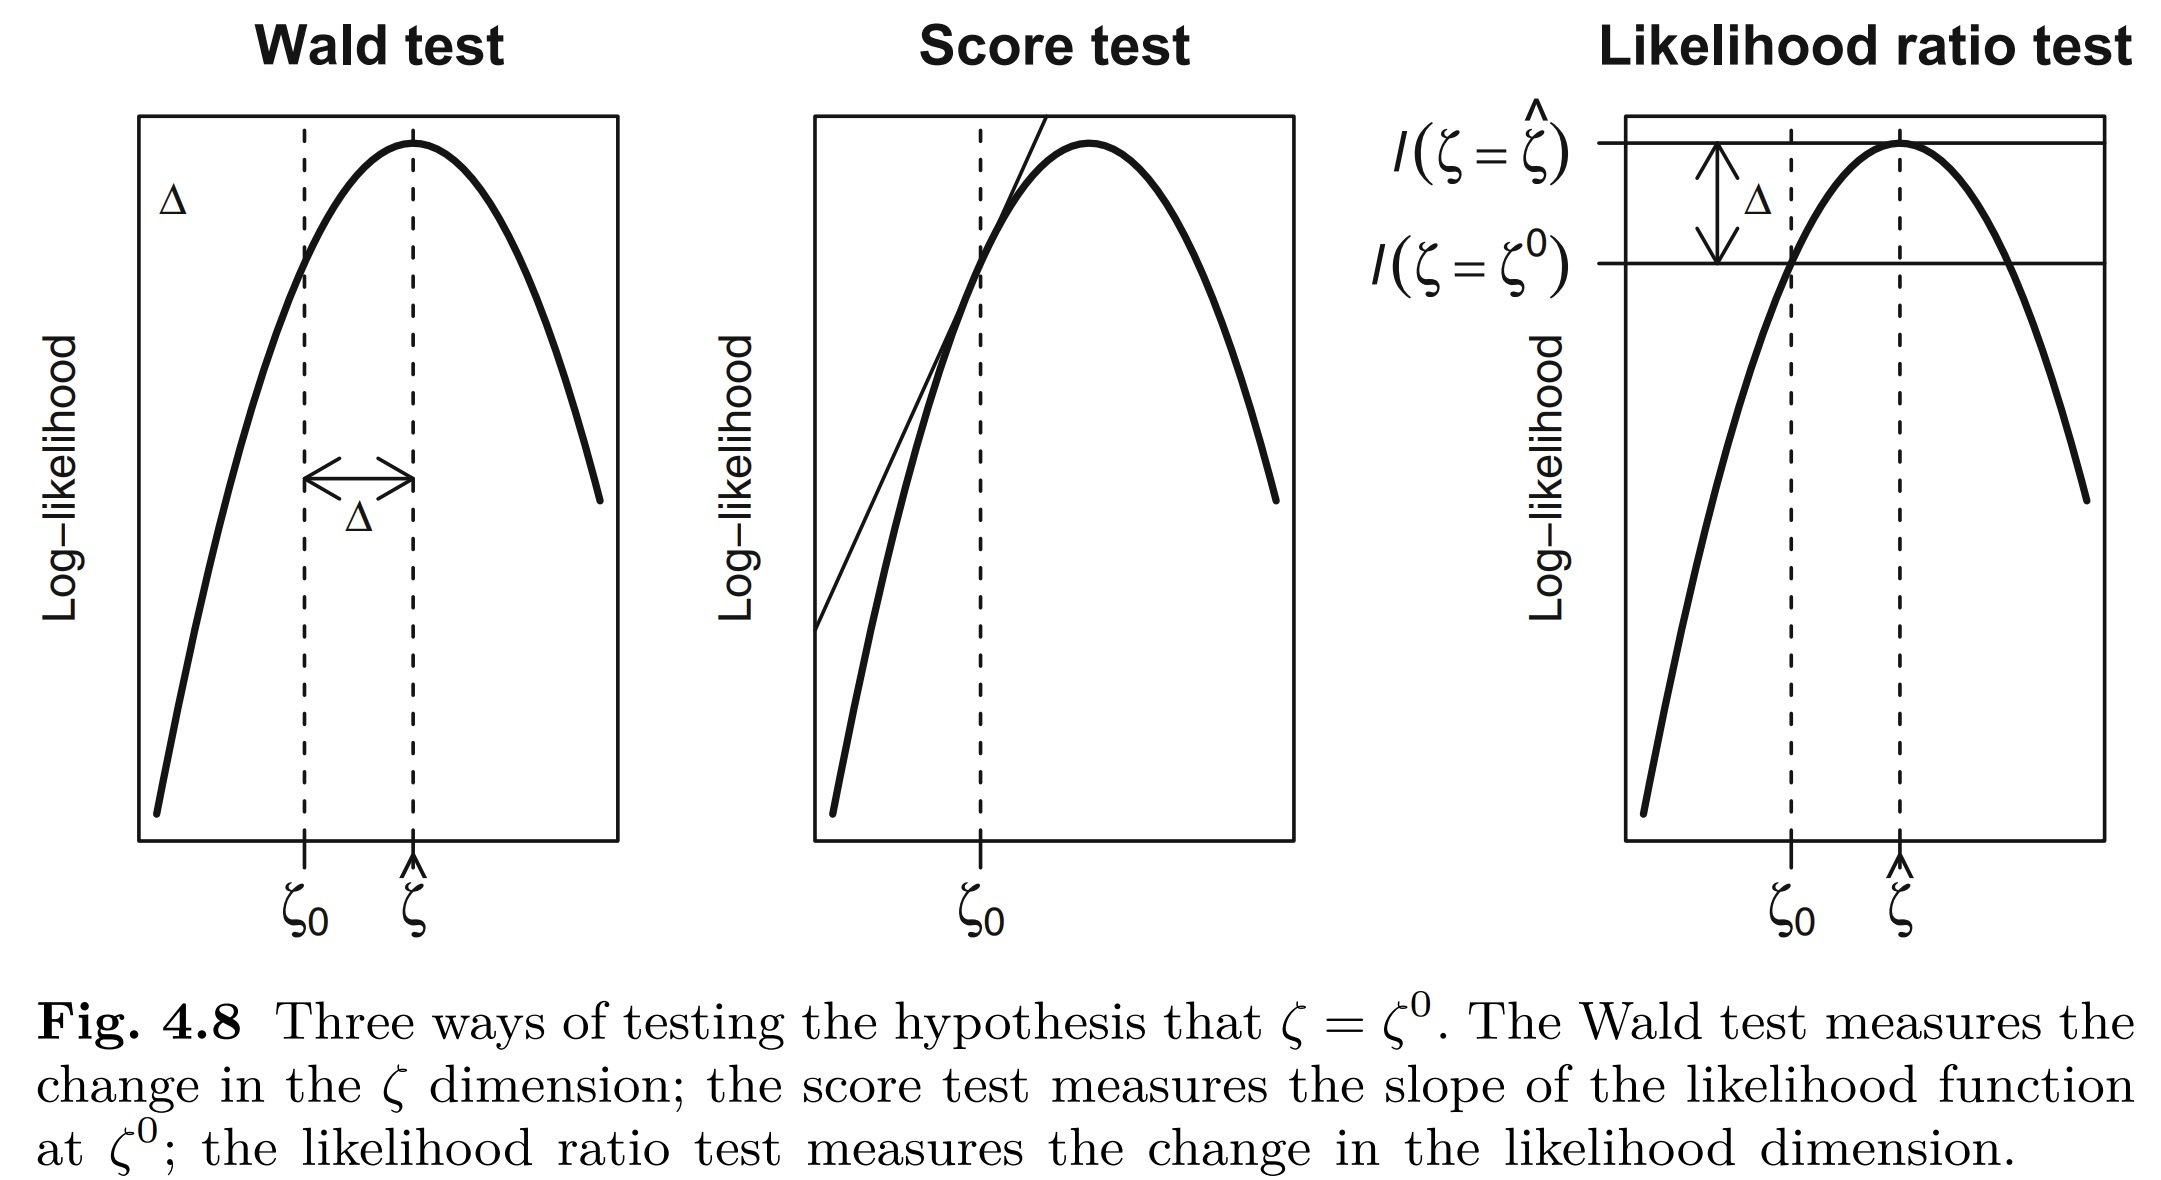

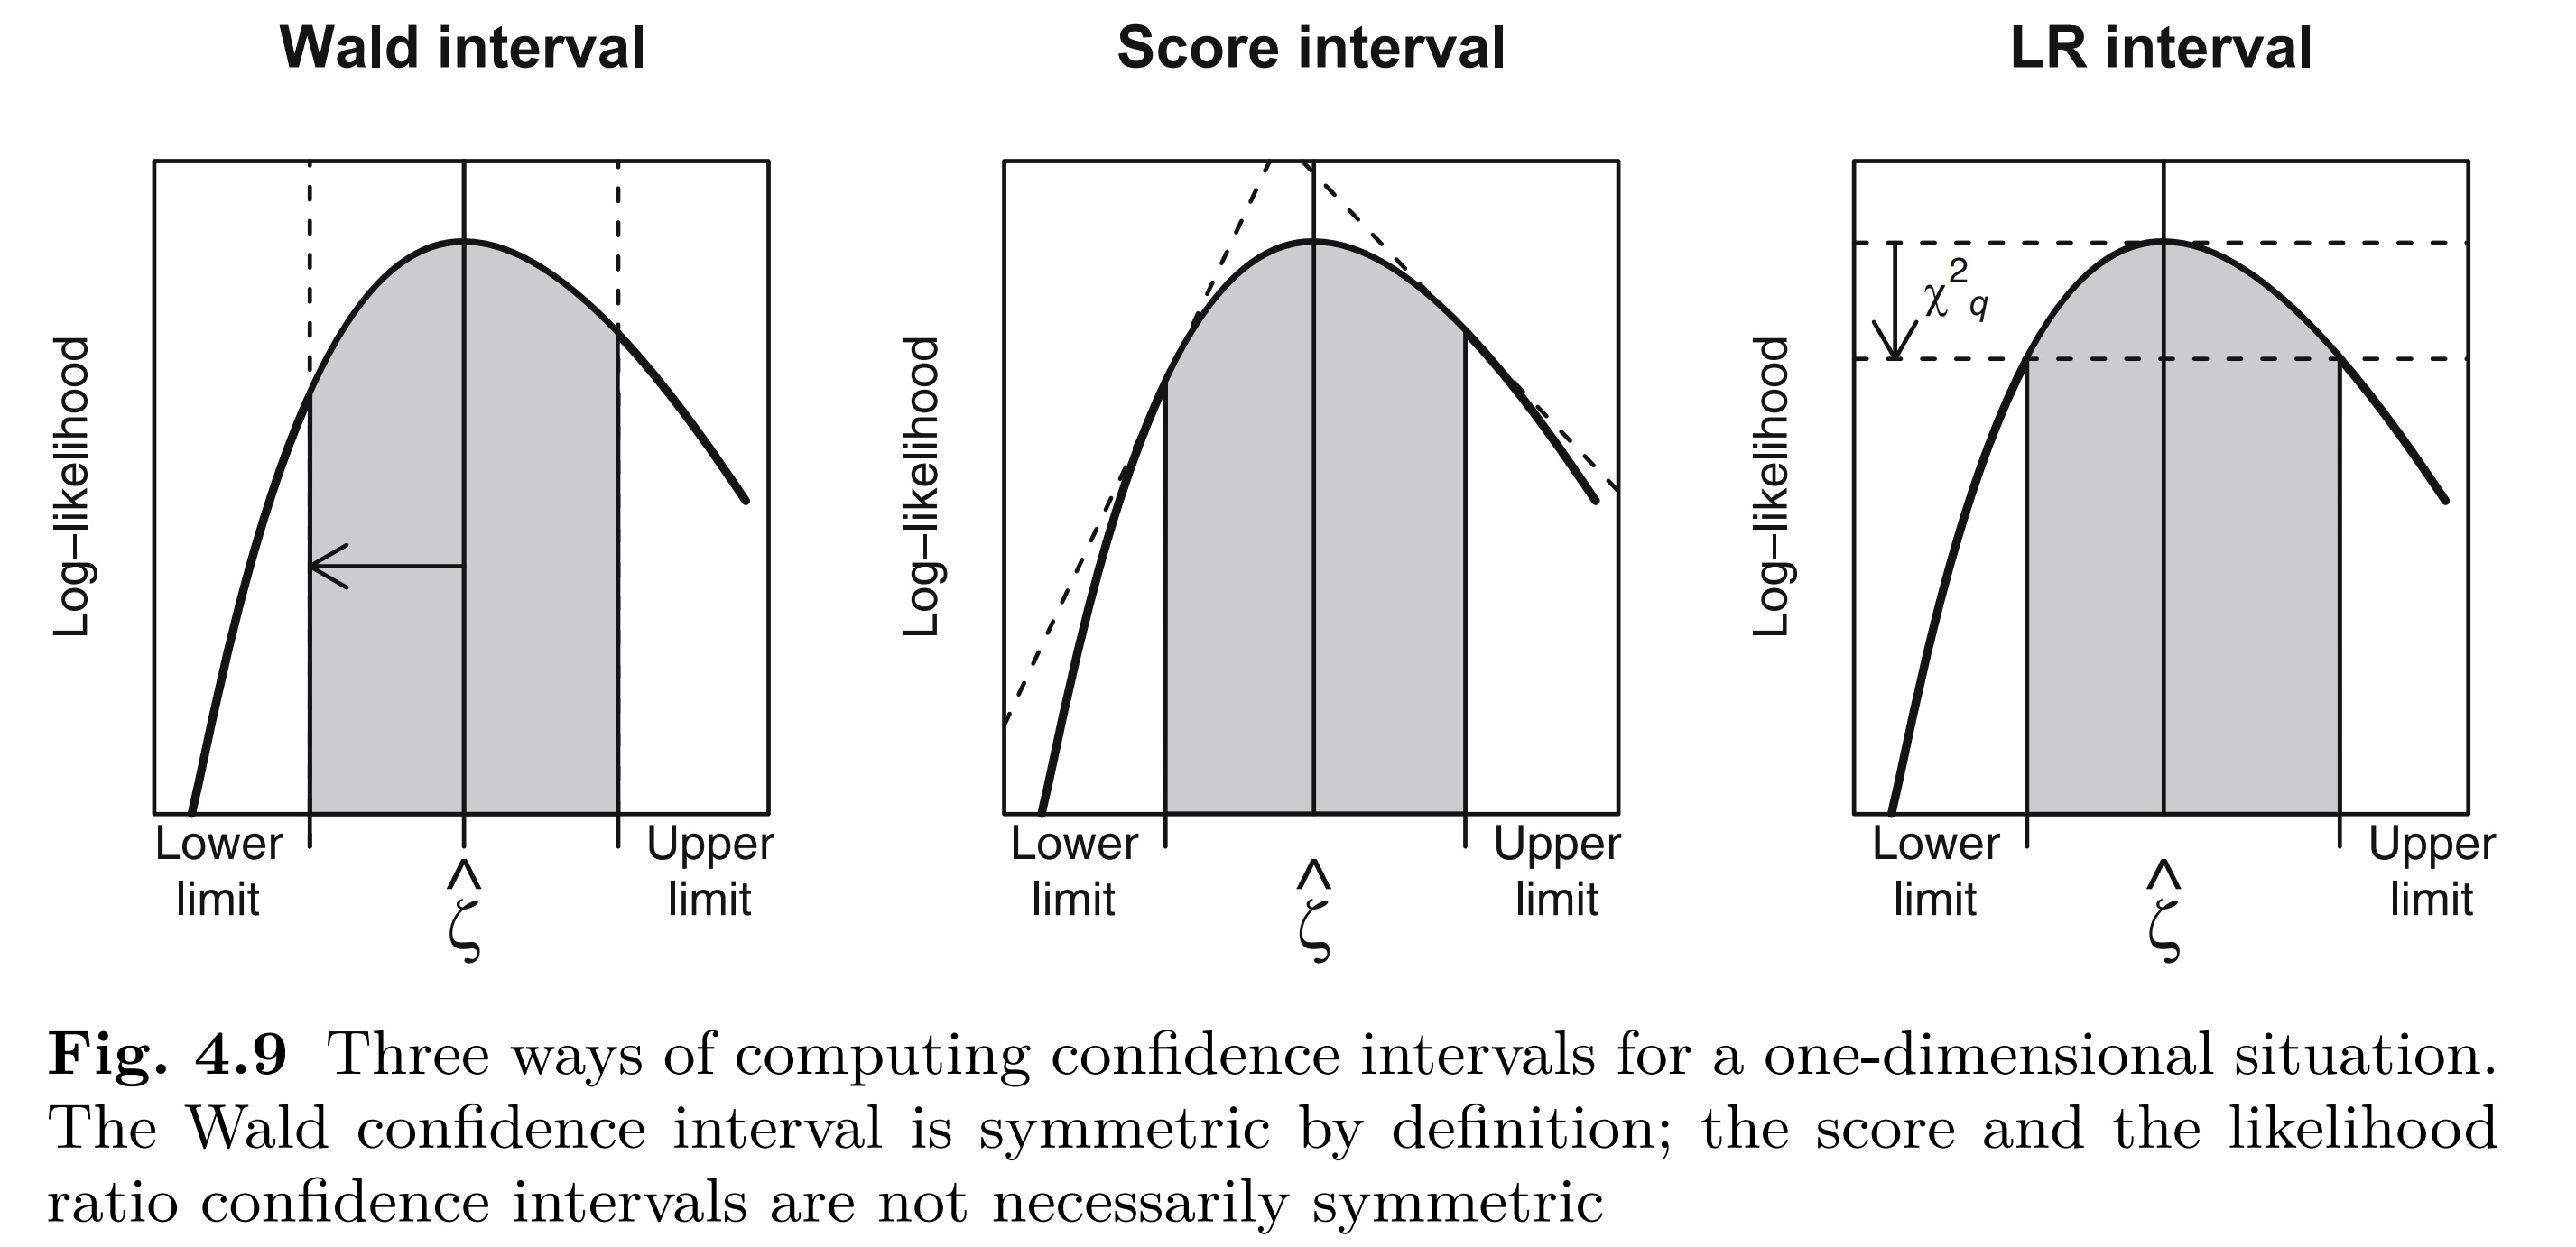

### Comparison of tests:
All three tests answer the same question: Can we leave out these predictor variables and reduce the fit of the model? 

All three tests can be used  when only one parameter appears in the model, or for all of the many parameters simultaneously, as well as for subsets of the parameters.

* Wald test is usually the easiest to perform
* Rao score tests  require less computational effort.
* Devince (i.e. Likelihood ratio tests) require two models to be fitted:


For Poisson model:
$$D = 2 \sum_{i=1}^n ( y_i log( \frac{y_i}{\hat{\mu_i}}) - ({y_i} - \hat{\mu_i}))$$

In [ ]:
mu_est_1 = model_1.predict()
Y = nminer['Minerab'].to_numpy()
np.sum(Y -mu_est_1)
Y0 = Y[Y>0]
mu0_est_1 = mu_est_1[Y>0]
Dev_1 = 2*np.sum(Y0*np.log(Y0/mu0_est_1))
print(Dev_1)
Dev_1 = 2*np.sum(Y0*np.log(Y0/mu0_est_1)) - 2*np.sum(Y -mu_est_1)
print(Dev_1)


`deviance` atribute of fitted model
Returns the residual deviance $D(y,\hat{\mu})$ for the fitted GLM.

In [ ]:
model_1.deviance

## Comparing Nested Models ($\phi$ is known)

### LRT Test

In [ ]:
model_0 = smf.glm(formula='Minerab~1', data=nminer, family=sm.families.Poisson()).fit()
model_1 = smf.glm(formula='Minerab~Eucs', data=nminer, family=sm.families.Poisson()).fit()

In [ ]:
print(f"Dev(m0)= {model_0.deviance}, Dev(m1) = {model_1.deviance}" )
print(f"df(m0)= {model_0.df_resid}, df(m1) = {model_1.df_resid}" )


L = model_0.deviance - model_1.deviance
print(L)

print(f'p val for lrt test: {scipy.stats.chi2.sf(L, df=model_0.df_resid - model_1.df_resid)}')

In [ ]:
anova = Anova()

anova(model_0, model_1, test='chisq')

In [ ]:
anova(model_0,model_1,test="LRT")

In [ ]:
anova(model_1, test="Chisq")

The P-value is very small, indicating that the addition of Eucs is significant.

### Score test

In [ ]:
# Add one variable  TODO /PREPARE FOR PYTHON/ statsmodels have some score_test but not tested
# score test for adding new variable to model => z-statistic
# or we can perform calculation by hand

 #? glm.scoretest

#z_stat = glm.scoretest(model_0, nminer.Eucs)
#p_val = 2 * scipy.stats.norm.sf(abs(z_stat))
#p_val

In [ ]:
# Compare model with saturated model
Y = nminer['Minerab']
X = nminer['Eucs']
mu_est_1 = model_1.predict()

Rao = np.sum((Y-mu_est_1)**2/mu_est_1)
print(Rao)
# p-hodnota testu adekvatnosti modelu (pomoci Raovy statistiky)
# H0: model dobre popisuje data
prao = scipy.stats.chi2.sf(Rao, df=model_1.df_resid) 
print(prao)

In [ ]:

I = np.diag(np.ones((len(Y),)))

model_s = sm.GLM(endog=Y.to_numpy(), exog=I, family=sm.families.Poisson()).fit()
model_f = smf.glm(formula='Minerab~Eucs', data=nminer, family=sm.families.Poisson()).fit()

display(anova(model_f, model_s, test='rao'))
anova(model_1, model_0, test='rao')


The evidence strongly suggests that Eucs should be added to the model.

## Estimating of $\phi$

* The Maximum Likelihood Estimator of $\phi$
* Pearson Estimator of $\phi$
* Mean Deviance Estimator of $\phi$

### Pearson Estimator of $\phi$

$$\phi = \frac{var[Y_i]}{a_i b''(\theta_i)} \Rightarrow \hat{\phi} = \frac{1}{n-p} \sum_{i=1}^{n} \frac{(y_i - \hat{\mu_i})^2}{a_i b''(\theta(\hat{\mu_i}))}$$

### Mean Deviance Estimator of $\phi$

$$\hat{\phi} = \frac{D(y,\hat{\mu})}{n-p}$$



For binomial and Poisson glms, $\phi = 1$ and no estimation is necessary. However, the issue may arise for over-dispersed binomial or Poisson GLMs,
which are considered in later exercises.

Use data `trees` and compute Pearson and Deviance estimator of $\phi$

In [ ]:
trees = pd.read_csv("https://github.com/aleksejalex/special-octo-engine/raw/main/datasets/dataset_trees_from_R.csv")

g = sns.PairGrid(trees)
g.map_diag(sns.kdeplot)
g.map_lower(sns.scatterplot)
g.map_upper(sns.histplot)

plt.show()

In [ ]:
trees

In [ ]:
mod_t_1 = smf.glm(formula = 'Volume ~ np.log(Height) + np.log(Girth)', data=trees,
                        family=sm.families.Gamma(sm.families.links.Log()))
model_trees_1 = mod_t_1.fit(scale='X2')

model_trees_1.summary()

In [ ]:
#Compute the Pearson estimator of $\phi$  
model_trees_1.resid_pearson.T @ model_trees_1.resid_pearson.T / model_trees_1.df_resid

In [ ]:
phi_meandev = model_trees_1.deviance / model_trees_1.df_resid
phi_pearson = model_trees_1.scale

print(f'Meand dev: {phi_meandev}; Pearson estimate: {phi_pearson}')

In [ ]:
print(mod_t_1.fit(scale='dev').summary())
print(mod_t_1.fit(scale='X2').summary())

Note though that R has now conducted z-tests using a normal distribution
instead of t-tests, treating the dispersion as known.

In [ ]:
model_trees_0 = smf.glm(formula='Volume~1', data=trees,
                        family=sm.families.Gamma(sm.families.links.Log())).fit()


# unfortunately statsmodels.glms have no `update functionality` as far as I know
# but we can perform simple string operation to update formula instead
model_trees_G = smf.glm(formula=model_trees_0.model.formula + '+ np.log(Girth)',
                        data=trees,
                        family=sm.families.Gamma(sm.families.links.Log())).fit()

model_trees_GH = smf.glm(formula=model_trees_G.model.formula + '+ np.log(Height)',
                        data=trees,
                        family=sm.families.Gamma(sm.families.links.Log())).fit() 

print(f'Deviances are: {model_trees_0.deviance}, {model_trees_G.deviance}, {model_trees_GH.deviance}')
print(f'Residual dfs are: {model_trees_0.df_resid}, {model_trees_G.df_resid}, {model_trees_GH.df_resid}')
dev1 = model_trees_0.deviance-model_trees_G.deviance
dev2 = model_trees_G.deviance-model_trees_GH.deviance
df1 = model_trees_0.df_resid-model_trees_G.df_resid
df2 = model_trees_G.df_resid-model_trees_GH.df_resid


In [ ]:
F_Pearson = ( dev1/df1, dev2/df2 ) / phi_pearson
F_meandev = ( dev1/df1, dev2/df2 ) / phi_meandev

P_Pearson = [scipy.stats.f.sf( i, df1, model_trees_GH.df_resid ) for i in F_Pearson]
P_meandev = [scipy.stats.f.sf( i, df2, model_trees_GH.df_resid) for i in F_meandev]
tab = pd.DataFrame(data={'F_pearson': F_Pearson, 'P_pearson': P_Pearson,
                         'F_meandev': F_meandev, 'P_meandev': P_meandev}, index=pd.Index(["Girth","Height"]))

tab

In [ ]:
display(anova(model_trees_GH, test="F", dispersion=phi_meandev))
anova(model_trees_GH, test="F", dispersion=phi_pearson)

In [ ]:
anova(model_trees_0, model_trees_GH, test="F")

Questions:
* What if I swap the order of independet varialbes in the definition `Volume ~ Girth + Height`?
* Compute scores by adding Girth and Height to the null model by `glm.scoretest() `in r package `statmod`. Try both directions.

## Comparing Non-nested Models: The AIC and BIC

Assume we want to compare the models:
$$Model \ 1: \ \text{log} \mu = \beta_0 +  2 x_1 + \beta_2 x_2$$
$$Model \ 2: \ \text{log} \mu = \beta_0 + \beta_1 x_1 + \ x_2$$


In [ ]:
Model_1 = smf.glm(formula='Volume~np.log(Height)', data=trees, offset=2*np.log(trees['Girth']),
                        family=sm.families.Gamma(sm.families.links.Log())).fit()

Model_2 = smf.glm(formula='Volume~np.log(Girth)', data=trees, offset=np.log(trees['Height']),
                        family=sm.families.Gamma(sm.families.links.Log())).fit()

print('AIC:', Model_1.aic, Model_2.aic)
print('BIC:', Model_1.bic_llf, Model_2.bic_llf)



In [ ]:
p = 2 +1 # dispersion parameter
n = len(trees['Volume'])
phi_hat = Model_1.scale

AIC  = -2*Model_1.llf + 2*p; print(AIC)
BIC  = -2*Model_1.llf + p*np.log(n); print(BIC)
# Model_1.summary()
AIC_dev = Model_1.deviance/phi_hat + 2*p; print(AIC_dev)

In [ ]:
Model_1.summary()

### Automated Selection  / prepare for Python /

In [ ]:
# TODO /implementation of step function is pending
model_0 = smf.glm(formula='Volume~1', data=trees,
                        family=sm.families.Gamma(sm.families.links.Log())).fit()
model_1 = smf.glm(formula='Volume~np.log(Height) + np.log(Girth)', data=trees,
                        family=sm.families.Gamma(sm.families.links.Log())).fit()


model_b1 = step(model_0, scope=list(lower=model_0, upper=model_1), direction="backward")
model_b2 = step(model_1, scope=list(lower=model_0, upper=model_1), direction="backward")
model_b3 = step(model_0, scope=list(lower=model_0, upper=model_1), direction="both")
model_b3


# Next week: Exercise 05

## GLM Diagnostics and Analysis of residuals



